# Gradient Boosting Regression from Scratch

## Prepare the Data

### Loading the Data

In [1]:
from sklearn import datasets
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load the california_housing toy dataset
ca_housing = datasets.fetch_california_housing(as_frame = True)

In [2]:
# Take a look at the dataframe
data = ca_housing["frame"]
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Print info about the dataframe
print(ca_housing["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

### Selecting Features and Target Variable

In [4]:
# We will only use the following 3 features
features = ["MedInc", "HouseAge", "AveRooms"]

In [5]:
# Separate features and target variable
X = data[features].copy()
y = data["MedHouseVal"].copy()

### Splitting Training and Test Set

In [6]:
import numpy as np

# Permute the dataframe to kill any possible ordering used
np.random.seed(0)      # Fix a random seed to allow reproducibility
old_index = data.index
new_index = np.random.permutation(old_index)

X = X.loc[new_index].reset_index(drop = True)
y = y.loc[new_index].reset_index(drop = True)

In [7]:
# Use 80% of the data for training purposes and the remaining 20% for testing purposes
train_test_cut = int(np.floor(len(X)*0.8))

In [8]:
# Create the training set
X_train = X.iloc[: train_test_cut].copy()
y_train = y.iloc[: train_test_cut].copy()

In [9]:
# Create the test set
X_test = X.iloc[train_test_cut :].copy()
y_test = y.iloc[train_test_cut :].copy()

In [10]:
print("The training set has {} samples".format(len(X_train)))
print("The test set has {} samples".format(len(X_test)))

The training set has 16512 samples
The test set has 4128 samples


## Implement a Gradient Boosting Regressor from Scratch

### Pseudo Code of the Training Algorithm

In the following we denote by $\bf x$ the collection of training samples, by $\bf y$ the corresponding target values and by $\overline {\bf y}$ the average of these values.

0. Create an empty list `fitted_gb_reg` to store the output data.
1. Initialize the algorithm with the average of the target values. In other words, set $F_0(\bf x) = \overline {\bf y}$, where $F_k(\bf x)$ are the values predicted by the algorithm during the $k$-th iteration (at this point we haven't done any iteration so $k=0$).
2. Append the value $\overline {\bf y}$ to the list `fitted_gb_reg`.
3. Calculate the residuals $\bf r$, i.e., the difference between the true values and the predicted values. In other words, $\textbf {r} = \textbf {y} - F_k(\textbf {x})$.
4. Train a decision tree $T_k$ on the samples $\bf x$ with target variable the residuals $\bf r$.
5. Calculate the leaves' output values using the average of the samples they contain.
6. Append the fitted tree $T_k$ to the list `fitted_gb_reg`.
7. Feed the samples $\bf x$ to $T_k$ and let $T_k(\bf x)$ be the outputted values. The new predicted values are $F_{k+1}(\textbf {x}) =  F_{k}(\textbf {x}) + \alpha T_k(\textbf {x})$, where $\alpha$ is the `learning rate` (an hyperparameter fixed at the beginning). 
8. Increase $k$ by 1.
9. If $k >$ `n_estimators` (where `n_estimators` is an integer hyperparameter fixed at the beginning), return `fitted_gb_reg`; else go back to step 3.

The list `fitted_gb_reg` returned by this algorithm represents a fitted instance of the Gradient Boosting Regressor.

### Coding the Training Algorithm

In [11]:
from sklearn.tree import DecisionTreeRegressor

def grad_boost_fit(X, y, n_estimators = 100, learning_rate = 0.1):  # We set the same hyperparameter default values used by
                                                                    # sklearn's instance of Gradient Boosting Regressor 
    """
    Fit my Gradient Boosting Regressor.
    
    :param X: the samples we use to train the model
    :type X: pandas.DataFrame of shape (n_samples, n_features)
    :param y: the target values of the training data
    :type y: pandas.Series of shape (n_samples,)
    :param n_estimators: the number of boosting stages to perform
    :type n_estimators: int, default = 100
    :param learning_rate: the learning rate used in the algorithm. It must be in range (0, infty)
    :type learning_rate: float, default = 0.1
    
    :return: gb_reg, a dictionary with the following attributes
    
                 fitted_gb_reg: a list containing all the decision trees created during the boosting stages
                            This list represents a fitted instance of the Gradient Boosting Regressor.
             
                 n_estimators: the max number of boosting stages performed
                 
                 learning_rate: the learning rate used in the algorithm

    """
    
    # STEP 0: initialize a list which will represent a fitted instance of the Gradient Boosting Regressor 
    fitted_gb_reg = []
    
    # STEP 1: initialize the algorithm with the mean of the target variable
    predictions = y.mean()
    
    # STEP 2: add this initial value to the list representing the fitted Gradient Boosting Regressor
    fitted_gb_reg.append(predictions)
    
    # Initialize a count of the number of boosting stages performed
    n_estimators_trained = 0
    
    # test STEP 9 condition: keep boosting until we reach the max number of stages
    while (n_estimators_trained < n_estimators):
        
        # STEP 3: calculate the residuals
        residuals = y - predictions
        
        # STEP 4: instantiate and fit a decision tree which predicts the residuals
        # STEP 5: because of the way sklearn's decision trees work, Step 5 is automatically performed at this point  
        tree = DecisionTreeRegressor(max_depth = 3, random_state = 1) # We set the same hyperparameter default values used by
                                                                      # sklearn's instance of Gradient Boosting Regressor 
                                                                      # We also set a random_state for reproducibility purposes
        _ = tree.fit(X, residuals)
        
        # STEP 6: add the fitted tree to the list representing the fitted Gradient Boosting Regressor
        fitted_gb_reg.append(tree)
        
        # STEP 7: use the tree to predict the residuals and update the predictions for the target values
        predicted_residuals = tree.predict(X)
        predictions += learning_rate * predicted_residuals
        
        # STEP 8: increase the number of boosting stages performed
        n_estimators_trained += 1
    
    # exit STEP 9 condition: the list we created represents a fitted instance of the Gradient Boosted Regressor
    gb_reg = {"model" : fitted_gb_reg,        # We return a dictionary containing the model and the hyperparameters we used
              "n_estimators" : n_estimators,
              "learning_rate" : learning_rate}
    
    return gb_reg

### Pseudo Code for Making Predictions

In the following `fitted_gb_reg` is the list representing the fitted Gradient Boosting Regressor we constructed above. Moreover,  we denote by $\hat {\bf x}$ the collection of new samples we are trying to predict and with $\hat {\bf y}$ the corresponding target values predicted by the model.

1. Set the initial predictions to be the value we used to initialize the training algorithm. In other words, set $\hat {\bf y} = $ `fitted_gb_reg[0]`.
2. For each decision tree $T_k$ in `fitted_gb_reg`, feed the samples $\hat {\bf x}$ to $T_k$ and get the outputted values $T_k(\hat {\bf x})$
    1. Feed the samples $\hat {\bf x}$ to $T_k$ and get the outputted values $T_k(\hat {\bf x})$.
    2. Set the new predicted values to be $\hat {\bf y} = \hat {\bf y} + \alpha T_k(\hat {\bf x})$, where              $\alpha$ is the `learning rate` that was established at the beginning of the training algorithm.  

From the description above it is clear that the final predictions are $\hat {\bf y} = \overline {\bf y} + \sum_ T\alpha T(\hat {\bf x})$, where the sum is taken over all the trees $T$ in `fitted_gb_reg[1:]`.

### Coding the Making Predictions

In [12]:
def grad_boost_predict(X, gb_reg):
    """
    Use a fitted instance of my Gradient Boosting Regressor to make predictions.
    
    :param X: the samples we want to predict
    :type X: pandas.DataFrame of shape (n_queries, n_features)
    :param gb_reg: a fitted instance of the Gradient Boosting Regressor
    :type gb_reg: dictionary
    
    :return: output, a dictionary with the following keys
    
                 "predictions", the predicted classes
                 
                 "n_estimators", the number of boosting stages performed during the training phase
                 
                 "learning_rate", the learning rate used in the algorithm
    """
    
     # Extract the model and hyperparameters from the input data
    fitted_gb_reg = gb_reg["model"]
    learning_rate = gb_reg["learning_rate"]
    n_estimators = gb_reg["n_estimators"]
    
    # STEP 1: set the initial predictions to be the value we used to initialize the training algorithm 
    predictions = fitted_gb_reg[0]
    
    # Loop through all the boosting stages
    for i in range(1, len(fitted_gb_reg)):
        
        # STEP 2A: feed the samples to the tree trained at the current stage and get the output values
        predicted_residuals = fitted_gb_reg[i].predict(X)
        
        # STEP 2B: update the model's predictions 
        predictions += learning_rate * predicted_residuals
    
    # Return a dataframe with the the predicted values and the hyperparameters used
    output = {"predictions" : predictions,
              "n_estimators" : n_estimators,
              "learning_rate" : learning_rate,
               }
    
    return output    

## Evaluating my Gradient Boosting Regressor

In [13]:
# Initialize a dictionary to evaluate the performance of my Gradient Boosting Regressor on the test data
my_test_errors = dict()
# Initialize the samples we want to predict (in this case, the test data)
X_hat = X_test

# Fit an instance of my Gradient Boosting Regressor and use it to predict the test data at different learning rates
# Evaluate the model using RMSE and collect all these values into a dictionary
for alpha in [x/10 for x in range(1, 11)]:  # We use learning the rates 0.1, 0.2, 0.3, ..., 1
    fitted_gb_reg = grad_boost_fit(X_train, y_train, learning_rate = alpha)
    my_test_predictions = grad_boost_predict(X_hat, fitted_gb_reg)["predictions"]
    my_test_errors[alpha] = np.sqrt((y_test - my_test_predictions).apply(lambda x : x**2).mean())

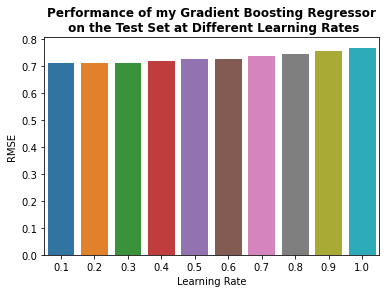

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the errors we obtain
sns.barplot(x = list(my_test_errors.keys()), y = list(my_test_errors.values()))
plt.xlabel("Learning Rate");
plt.ylabel("RMSE");
plt.title("Performance of my Gradient Boosting Regressor\n on the Test Set at Different Learning Rates", weight = "bold");

## Comparing my Model to sklearn's Implementation of Gradient Boosting Regressor

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Now do the same thing using the sklearn's Gradient Boosting Regressor

sklearn_test_errors = dict()

for alpha in [x / 10 for x in range(1, 11)]:
    gb_regr = GradientBoostingRegressor(learning_rate = alpha, random_state = 1)
    gb_regr.fit(X_train, y_train)
    sklearn_test_predictions = gb_regr.predict(X_test)  
    sklearn_test_errors[alpha] = np.sqrt((y_test - sklearn_test_predictions).apply(lambda x : x**2).mean())

GradientBoostingRegressor(random_state=1)

GradientBoostingRegressor(learning_rate=0.2, random_state=1)

GradientBoostingRegressor(learning_rate=0.3, random_state=1)

GradientBoostingRegressor(learning_rate=0.4, random_state=1)

GradientBoostingRegressor(learning_rate=0.5, random_state=1)

GradientBoostingRegressor(learning_rate=0.6, random_state=1)

GradientBoostingRegressor(learning_rate=0.7, random_state=1)

GradientBoostingRegressor(learning_rate=0.8, random_state=1)

GradientBoostingRegressor(learning_rate=0.9, random_state=1)

GradientBoostingRegressor(learning_rate=1.0, random_state=1)

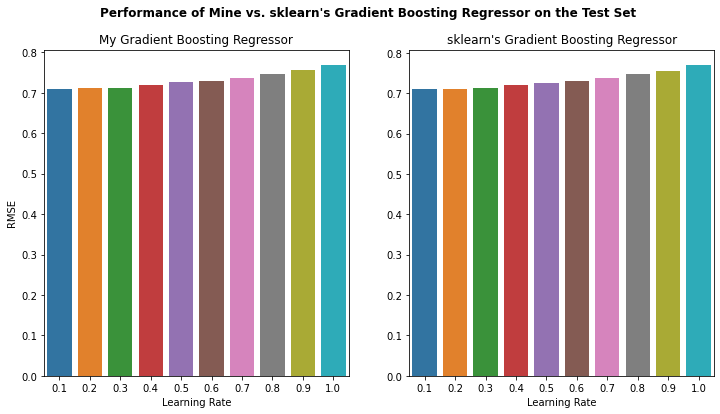

In [16]:
# Compare my Gradient Boosting Regressor with the one from sklearn by plotting side by side the errors each of them yields 
# on the test data

fig, axs = plt.subplots(1,2, figsize = (12, 6))

_ = sns.barplot(x = list(my_test_errors.keys()), y = list(my_test_errors.values()), ax = axs[0]);
_ = sns.barplot(x = list(sklearn_test_errors.keys()), y = list(sklearn_test_errors.values()), ax = axs[1]);

_ = axs[0].set_ylabel("RMSE")

for ax in axs:
    _ = ax.set_xlabel("Learning Rate")

_ = axs[0].set_title("My Gradient Boosting Regressor")    
_ = axs[1].set_title("sklearn's Gradient Boosting Regressor")    

_ = fig.suptitle("Performance of Mine vs. sklearn's Gradient Boosting Regressor on the Test Set", weight = "bold")